**2D Moon Lander**

This model controlling a VTVL lander landing on moon.
There is no air resistance on moon, the gravitational acceleration is very small  $g=1.6m/s^2$ .
A rocket engine on the bottom can provide enough thrust to against gravity.
A momentum wheel on the centroid provide torque for orientation of the lander.
A flat landing field already been found.

In [185]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [186]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 1.2  # gravity constant
BOOST_ACCEL = 1.8  # thrust constant
LANDING_FIELD_WIDTH = 2.5  # landing field width
LANDING_FIELD_HEIGHT = 0.  # ground
w1 = [-LANDING_FIELD_WIDTH, LANDING_FIELD_WIDTH]
w2 = [0.1*-LANDING_FIELD_WIDTH, 0.1*LANDING_FIELD_WIDTH] # center of landing field
h =  [LANDING_FIELD_HEIGHT,LANDING_FIELD_HEIGHT] # ground
ROTATION_ACCEL = np.radians(20)  # rotational acceleration

Action: $u = [a, \alpha]$ <br />
$a$ = thrust (max = $1.8m/s^2$) <br />
$\alpha$ = angular acceleration (max = $\pm 20^{\circ}/s^2$)

State: $x = [\theta, \omega, x, v_x, y, v_y]$ <br />
$\theta$ = angle of orientation <br />
$\omega$ = angular velocity <br />
$x$ = horizontal position <br />
$v_x$ = horizontal velocity <br />
$y$ = height <br />
$v_y$ = vertical position <br />

Because the sensors have several millimeter uncertainty, the random errors are added to each step of states: <br />
$e = Pr(x(t))$

Discrete-time dynamic equation: <br />
$\theta(t+1) = \theta(t) + \omega(t) \Delta t + Pr(\theta(t))$ <br />
$\omega(t+1) = \omega(t) + \alpha \Delta t + Pr(\omega(t))$ <br />
$x(t+1) = x(t) \Delta + v_x(t) t + Pr(x(t))$ <br />
$v_x(t+1) = v_x(t) - a * sin(\theta(t)) \Delta t + Pr(v_x(t))$ <br />
$y(t+1) = y(t) + v_y(t) \Delta t + Pr(y(t))$ <br />
$v_y(t+1) = v_y(t) + a * cos(\theta(t)) \Delta t - g \Delta t + Pr(v_y(t))$ <br />

In [187]:
# define system dynamics
# Notes:
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action, n):

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])

        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1) + 0.001*(t.rand(n,6)-0.5)*t.tensor([.1,.1,1.,1.,1.,1.]) # Add noises

        return state

In [188]:
# a deterministic controller
# Note:
# nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

The "initialize_state" function $Pr(x(0))$ randomness generate N number of initial conditions of the lander to optimize the controller over a distribution of initial states.

The "error()" function define the objective function of optimization: <br />
$\begin{aligned} min_\theta &= \frac{1}{N} \sum^N_{i=1} E_i = \frac{1}{N} \sum^N_{i=1} ||x(T)_i||*weight \end{aligned}$ <br />
where T is final time, $weight = [1,1,1,0.01,1,1]$ is the weighting factor of each state.
The final horizontal position does not need to be exactly the center of landing field, so its factor is 0.01:

In [189]:
# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action, n)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [math.pi/6*(random.random()-0.5), math.pi/12*(random.random()-0.5), # orientation state
                     10.*(random.random()-0.5), (random.random()-0.5), # horizontal state
                     5.*random.random()+10., -random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [190]:
# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1, line_search_fn='strong_wolfe')

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(n):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [191]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.6f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

After activate the program, the Simulator generates 500 initial states of lander.
The training process stop when the average loss $E^2 < 0.001$.

Generate 500 initial states of rocket:
[[ 1.56656791e-01  8.28266348e-02 -1.33106050e+00 -5.47529133e-02
   1.25700239e+01 -3.25681080e-01]
 [-2.57884015e-01 -2.13113806e-02 -1.62814200e+00 -3.85798396e-01
   1.40876583e+01 -2.41490222e-01]
 [-1.99649756e-01  6.16886392e-02 -4.87161127e+00  5.65042931e-03
   1.28300720e+01 -5.15230640e-01]
 ...
 [ 2.12015363e-01 -6.83701328e-02  3.91282797e+00  3.92151718e-01
   1.08144033e+01 -4.58031537e-01]
 [ 1.95189900e-01 -3.12962944e-02  1.57242860e+00 -4.28465432e-01
   1.45082595e+01 -8.18862157e-01]
 [-6.97489298e-02  4.87555850e-02 -8.62780445e-01 -2.68158522e-01
   1.30737342e+01 -4.85433696e-01]]
Start Training:
[1] loss: 39.282970


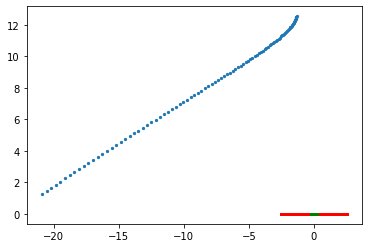

[2] loss: 10.538593


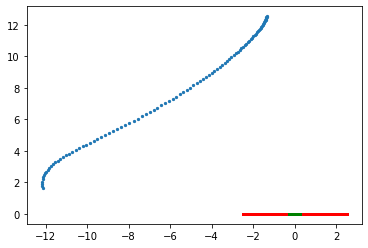

[3] loss: 3.469839


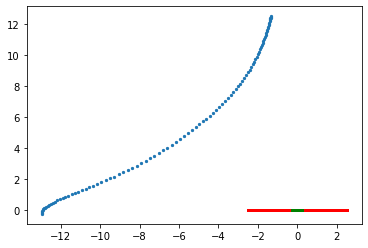

[4] loss: 0.871660


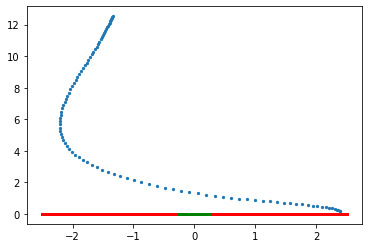

[5] loss: 0.189446


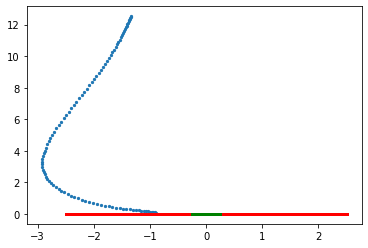

[6] loss: 0.042661


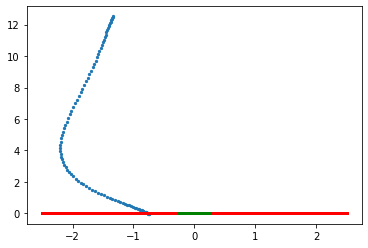

[7] loss: 0.014599


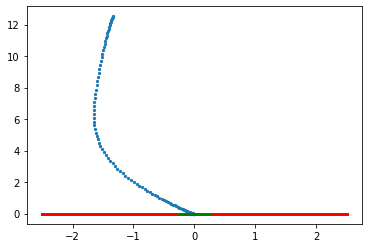

[8] loss: 0.005835


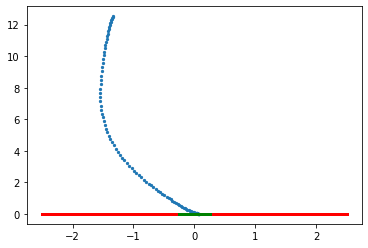

[9] loss: 0.003606


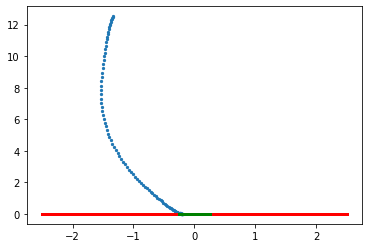

[10] loss: 0.002788


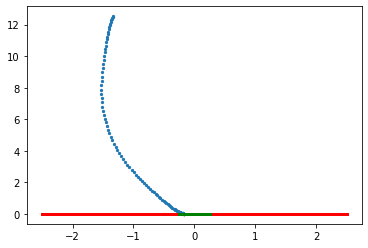

[11] loss: 0.001846


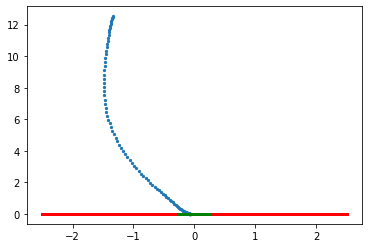

[12] loss: 0.001691


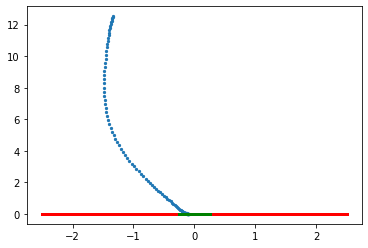

[13] loss: 0.001623


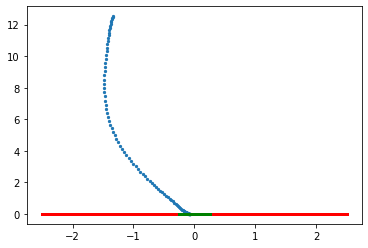

[14] loss: 0.001630


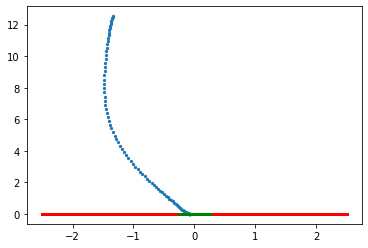

[15] loss: 0.001617


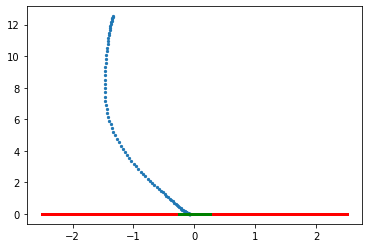

[16] loss: 0.001601


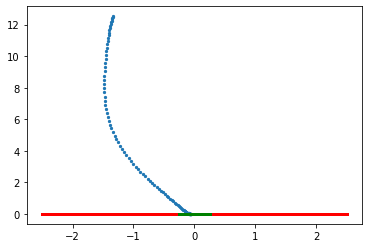

[17] loss: 0.001569


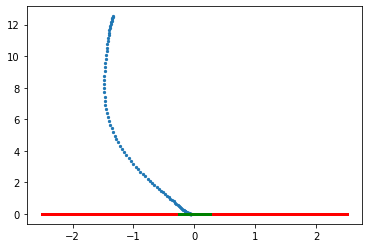

[18] loss: 0.001553


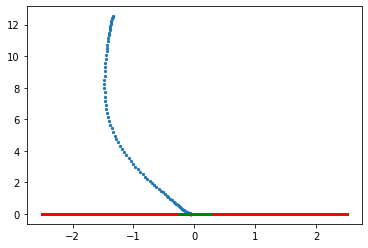

[19] loss: 0.001501


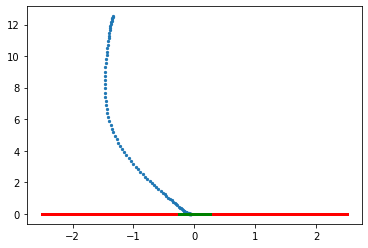

[20] loss: 0.001418


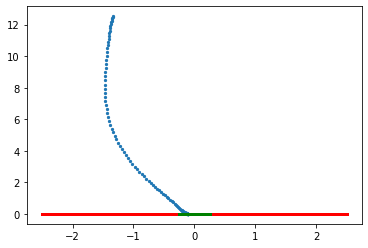

[21] loss: 0.001352


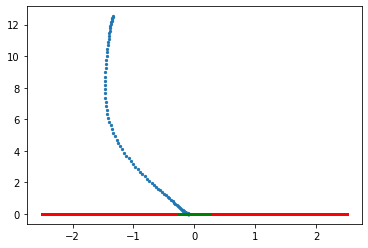

[22] loss: 0.001308


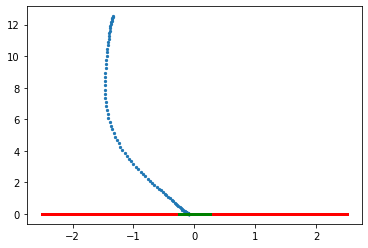

[23] loss: 0.001303


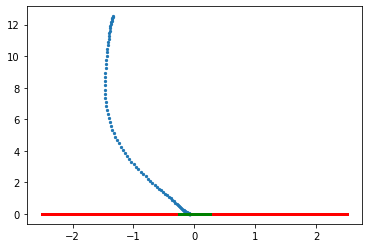

[24] loss: 0.001261


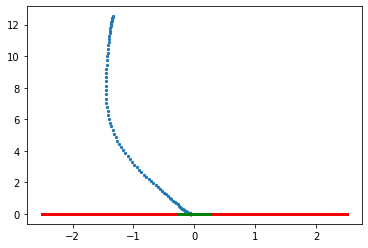

[25] loss: 0.001242


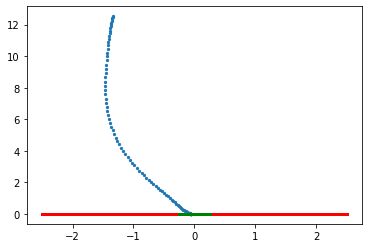

[26] loss: 0.001237


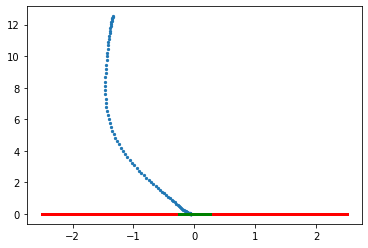

[27] loss: 0.001220


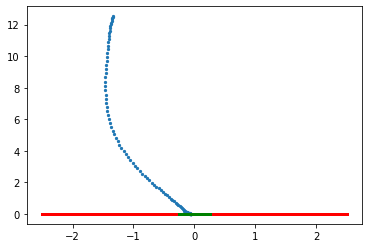

[28] loss: 0.001224


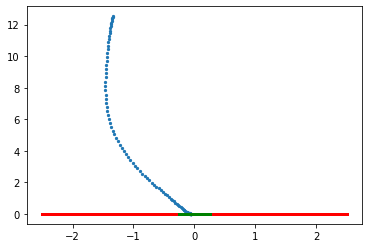

[29] loss: 0.001224


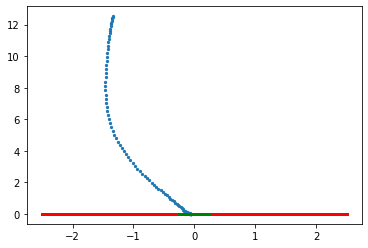

[30] loss: 0.001225


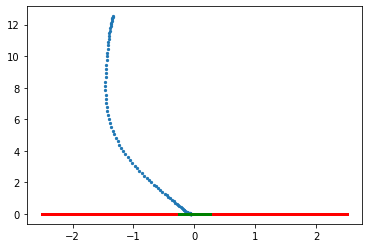

[31] loss: 0.001222


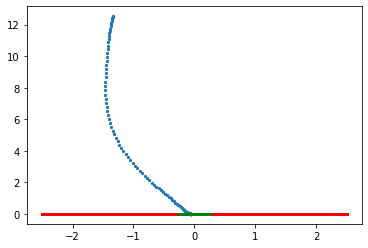

[32] loss: 0.001223


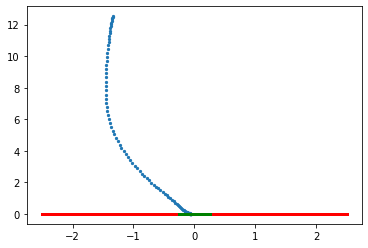

[33] loss: 0.001213


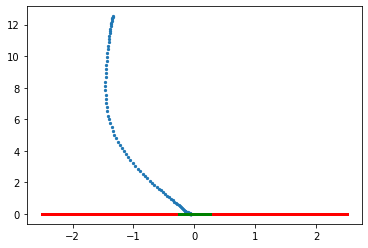

[34] loss: 0.001179


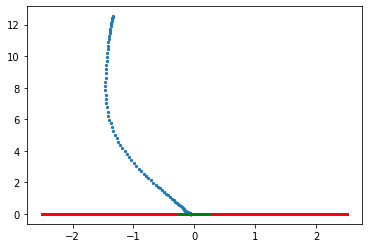

[35] loss: 0.001172


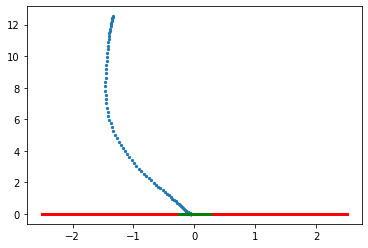

[36] loss: 0.001165


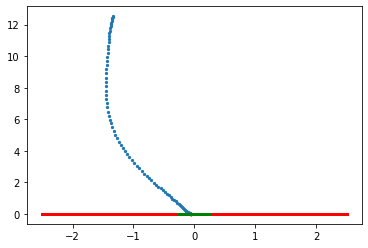

[37] loss: 0.001160


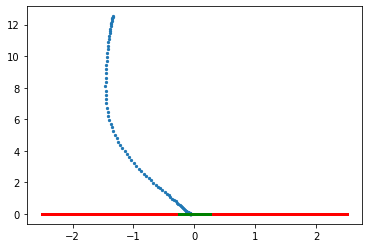

[38] loss: 0.001149


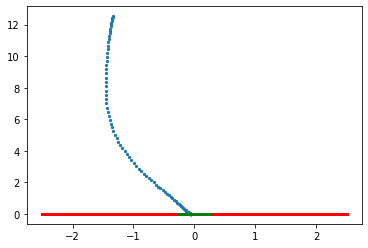

[39] loss: 0.001148


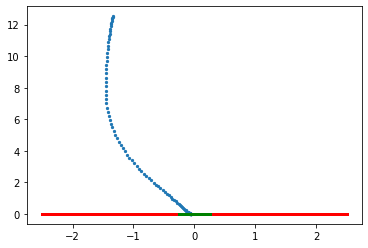

[40] loss: 0.001109


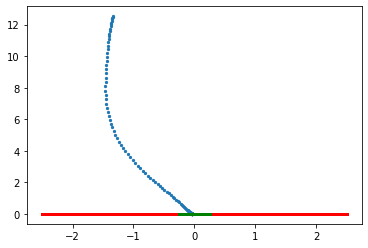

[41] loss: 0.001111


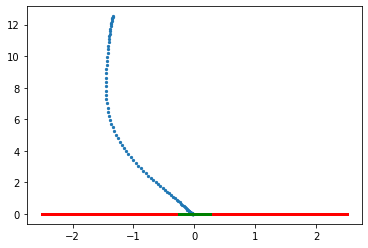

[42] loss: 0.001112


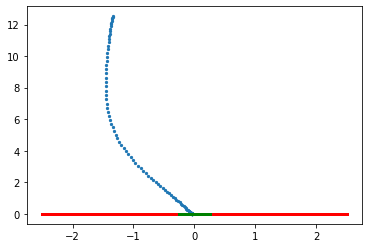

[43] loss: 0.001108


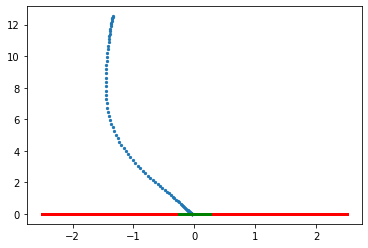

[44] loss: 0.001106


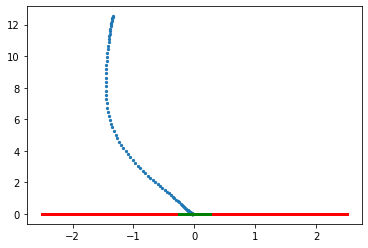

[45] loss: 0.001100


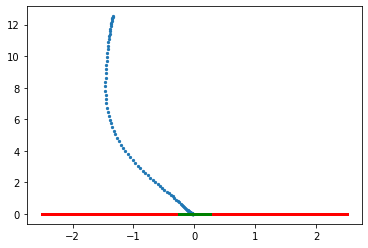

[46] loss: 0.001096


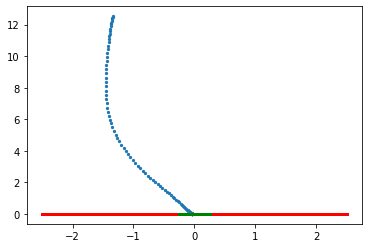

[47] loss: 0.001095


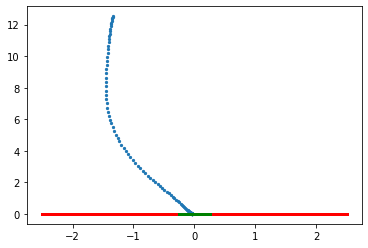

[48] loss: 0.001096


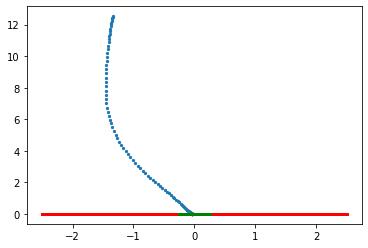

[49] loss: 0.001084


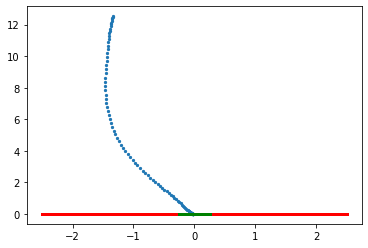

[50] loss: 0.001077


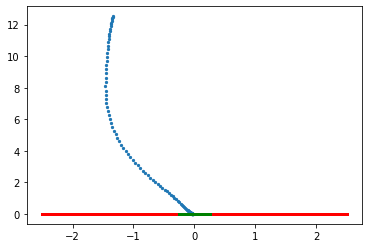

[51] loss: 0.001078


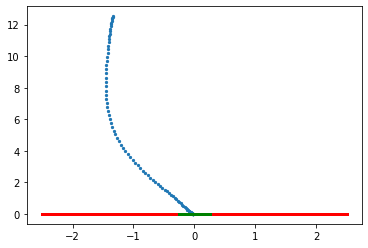

[52] loss: 0.001077


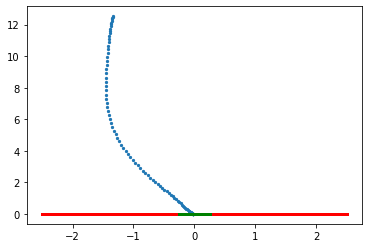

[53] loss: 0.001076


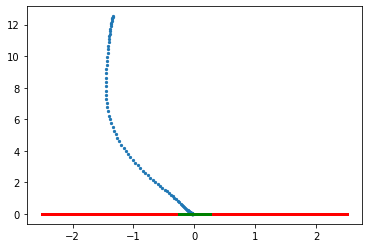

[54] loss: 0.001066


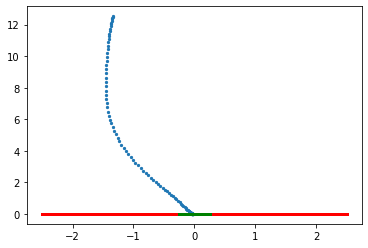

[55] loss: 0.001069


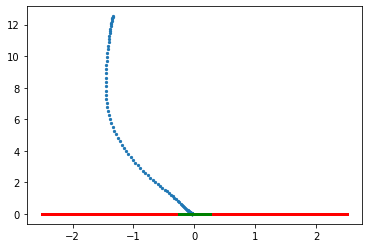

[56] loss: 0.001062


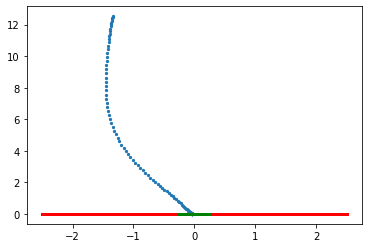

[57] loss: 0.001051


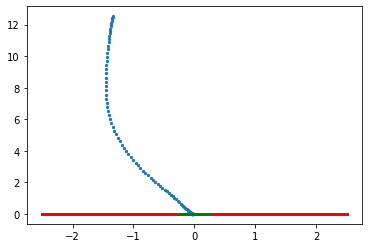

[58] loss: 0.001030


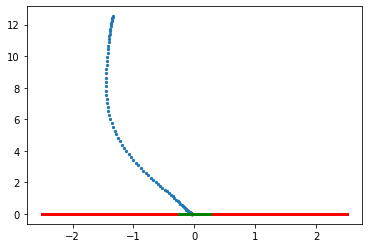

[59] loss: 0.001033


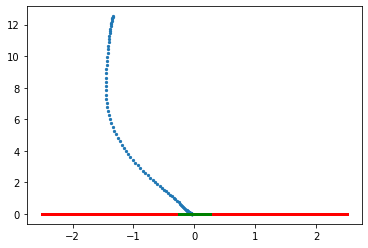

[60] loss: 0.001028


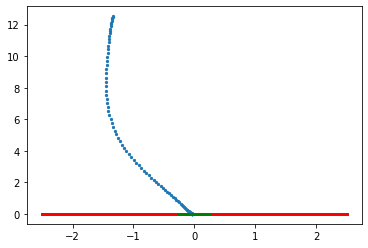

[61] loss: 0.001022


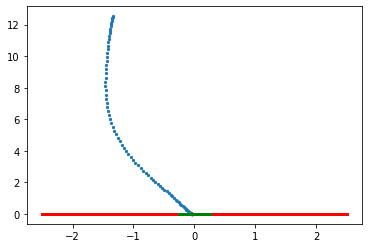

[62] loss: 0.001021


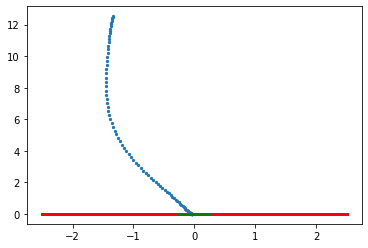

[63] loss: 0.001010


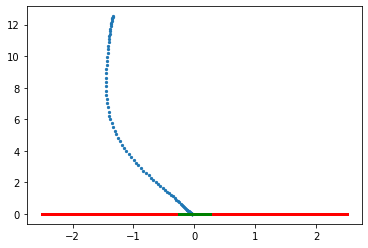

[64] loss: 0.000994


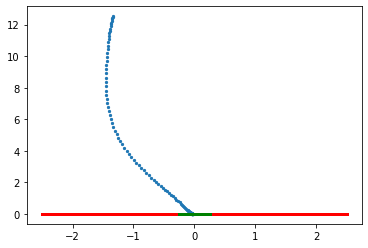

Convergence Plot:


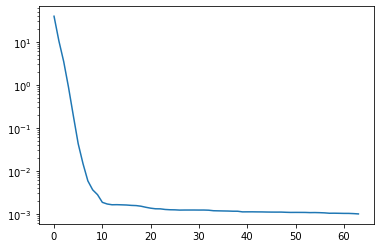

In [192]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 500  # number of initial states
err = 0.001 # acceptable_error
itr = 100 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

According to the convergence plot, the optimizer work well until the error is close to $10^{-3}$.
This phenomenon is mainly caused by the several millimeter ($10^{-3} m$) uncertainty of sensors.

Finally, the trained model is sent to evaluate.
The Simulator generates 10 new initial states to test the performance of the controller:

10
Generate 10 initial states of rocket:
[[-3.43969969e-02  7.93863982e-02 -1.19265152e+00 -5.45179834e-02
   1.37201197e+01 -7.93838966e-01]
 [ 1.46792508e-01 -5.50286673e-02 -1.51532334e+00 -3.40585761e-01
   1.30206302e+01 -2.09634704e-01]
 [ 3.38749736e-02  1.14249199e-01 -4.52649979e+00  4.30762903e-01
   1.12625021e+01 -1.34817799e-01]
 [ 1.91075175e-01 -5.20325674e-02  3.03930950e+00 -1.97539975e-01
   1.41097240e+01 -8.12497916e-01]
 [ 1.19418136e-01  4.94923776e-02 -4.43070531e+00 -2.57743985e-01
   1.42129960e+01 -8.63704014e-01]
 [ 1.65338464e-01  3.04195829e-04 -5.07224638e-02 -3.51358064e-01
   1.41179117e+01 -6.70346317e-01]
 [ 6.79771018e-02 -8.25580714e-02 -4.20205847e+00 -1.58352618e-01
   1.20996027e+01 -1.89171774e-01]
 [ 2.17264759e-01 -1.16036146e-01 -3.72367815e+00  3.35304411e-01
   1.04954887e+01 -7.18286744e-01]
 [ 1.30021327e-01 -1.14275488e-01  3.74825406e+00  7.16951796e-02
   1.36673110e+01 -7.03011256e-01]
 [ 2.08408655e-01  8.02062205e-02  2.90995397e+00 

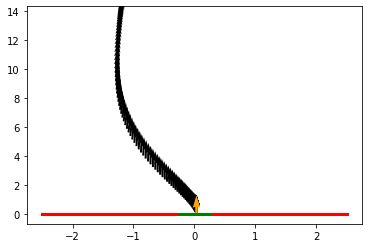

[0.00173933 0.00362894 0.03525431 0.00711586 0.00198634 0.00322921]


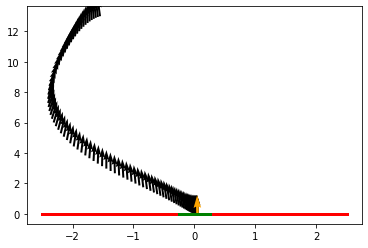

[0.01724643 0.01672994 0.05138848 0.01142333 0.00407322 0.00663715]


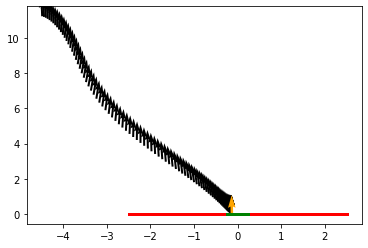

[0.01260875 0.01433949 0.13098282 0.0038055  0.00447679 0.0072829 ]


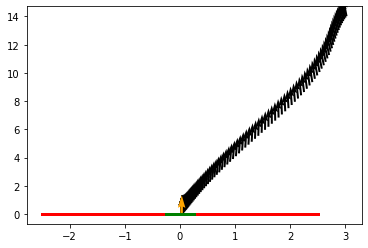

[0.00757042 0.01340621 0.02843081 0.00399857 0.00383075 0.0093477 ]


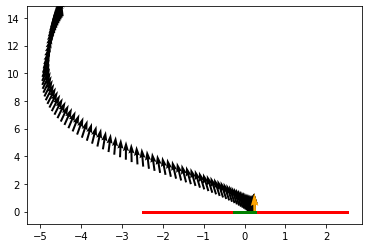

[0.02119655 0.02102661 0.24931297 0.00807557 0.01939389 0.04217128]


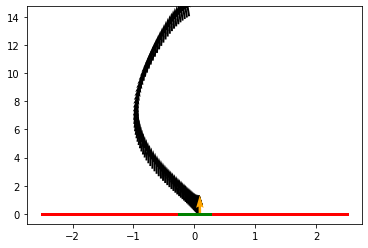

[0.00707592 0.00587679 0.091177   0.00508703 0.00251989 0.00317187]


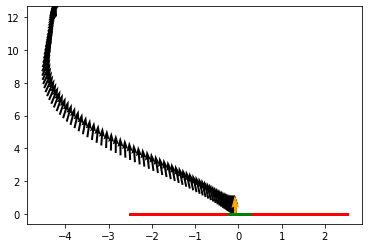

[0.02700932 0.02785685 0.0699593  0.0118295  0.00325312 0.00592279]


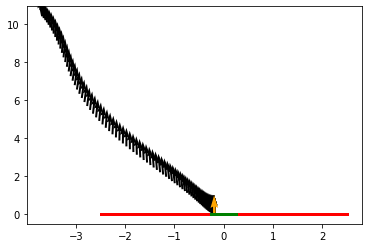

[0.00957663 0.009414   0.18872948 0.00461276 0.00158976 0.00094053]


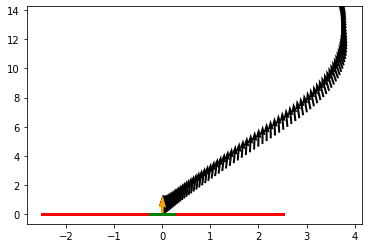

[0.0184005  0.02730353 0.00132614 0.0017302  0.00196087 0.00690422]


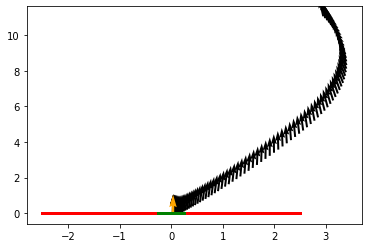

[0.00901756 0.01583122 0.03462827 0.00420453 0.002325   0.00137426]


In [193]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()
print(N_eval)
s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test

The average error of each state except horizontal position are approximately 0.01, the Lander Legs can absorb this level of impact.
The position error is less than 10% of radius of the landing field.